In [2]:
import numpy as np
import pandas as pd
import time
import json
from toolbox.figures import set_matplotlib_style
set_matplotlib_style()

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from toolbox.machine_learning import get_features_sets, get_data, balance_data
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Scenario: present-day, Features: Highly-Aggregated, Accuracy: 0.6207348427117534, Duration: 142.1145360469818
Confusion matrix for present-day and Highly-Aggregated


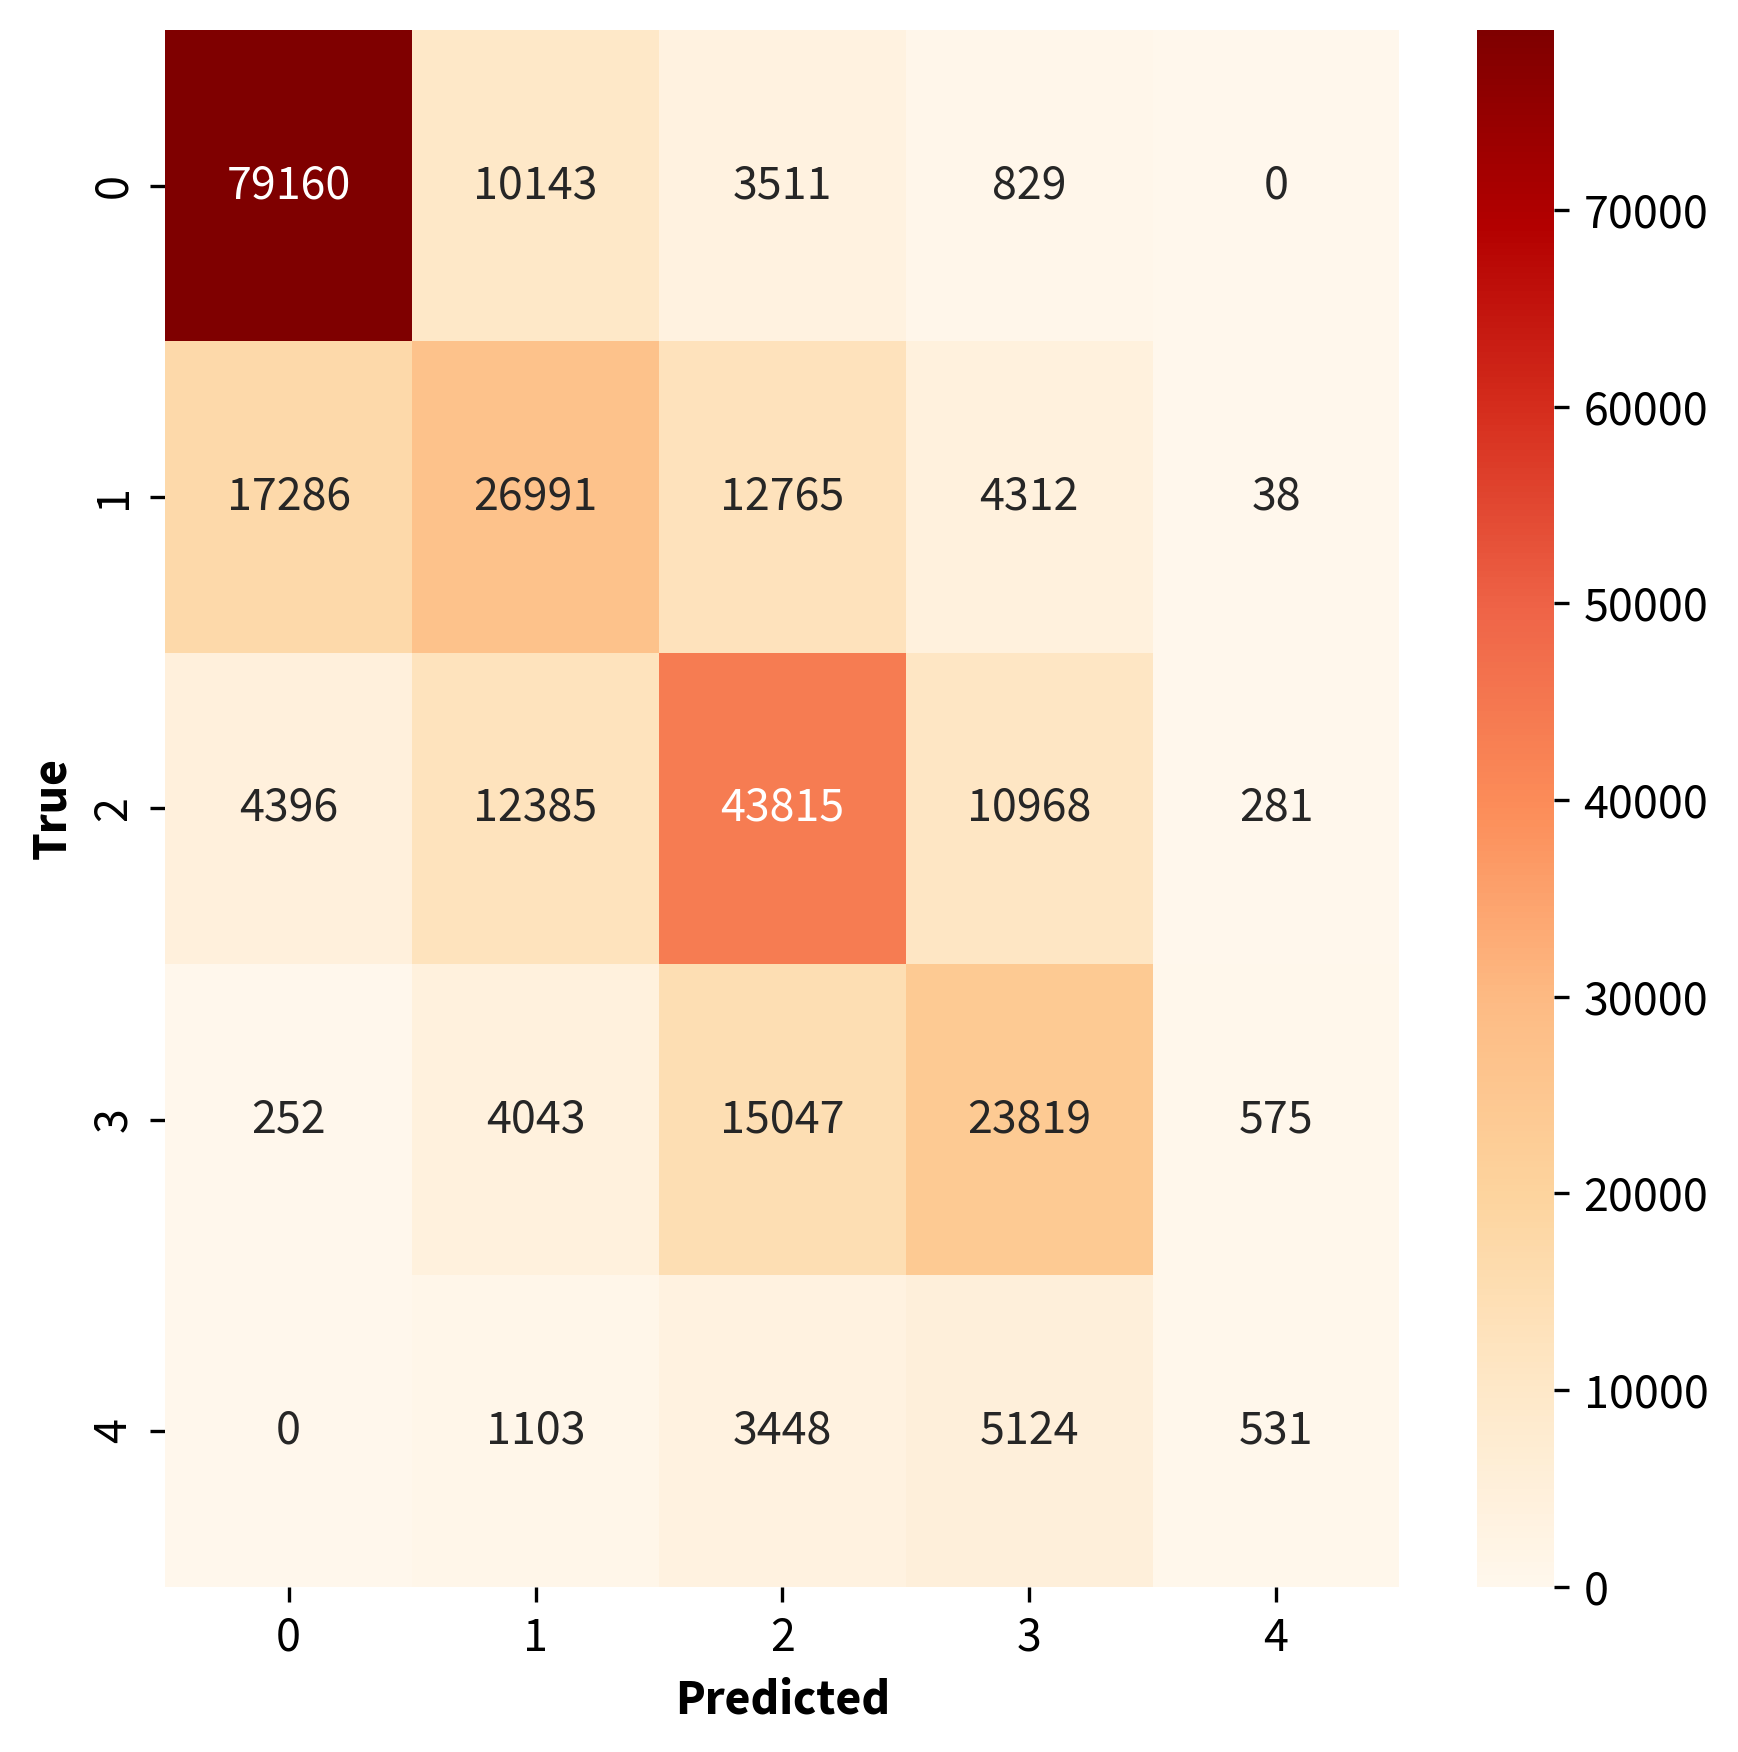

Done in total duration: 147.86298298835754
Scenario: present-day, Features: Aggregated, Accuracy: 0.8673394534616233, Duration: 217.86789274215698
Confusion matrix for present-day and Aggregated


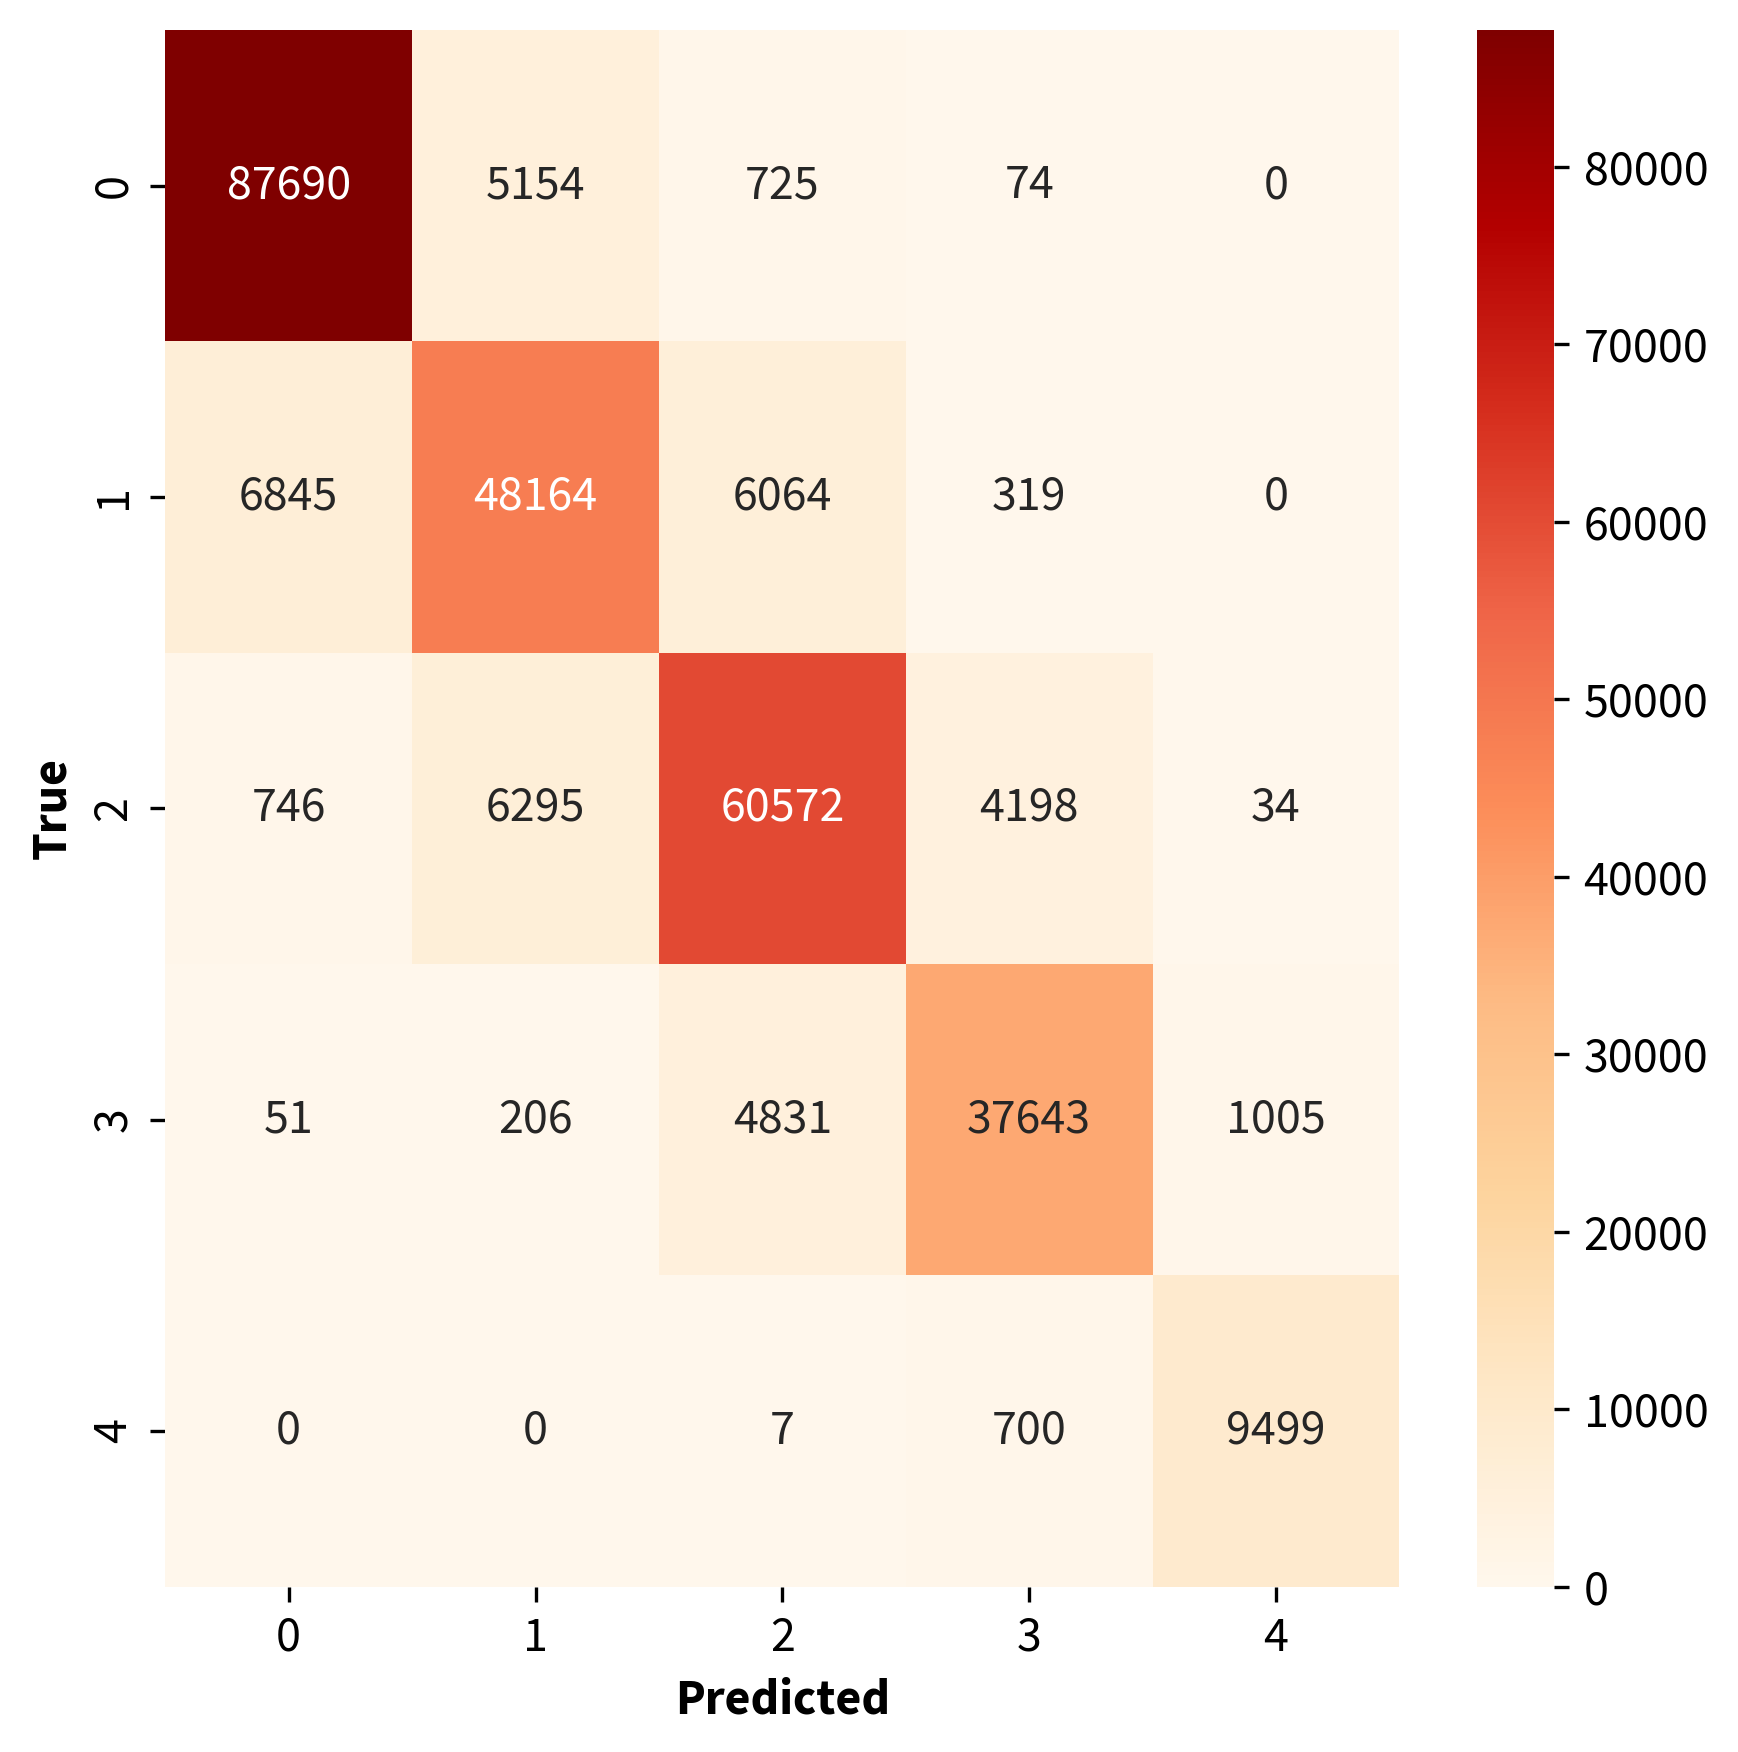

Done in total duration: 229.87885785102844
Scenario: present-day, Features: Reduced, Accuracy: 0.8725206714573644, Duration: 275.04908204078674
Confusion matrix for present-day and Reduced


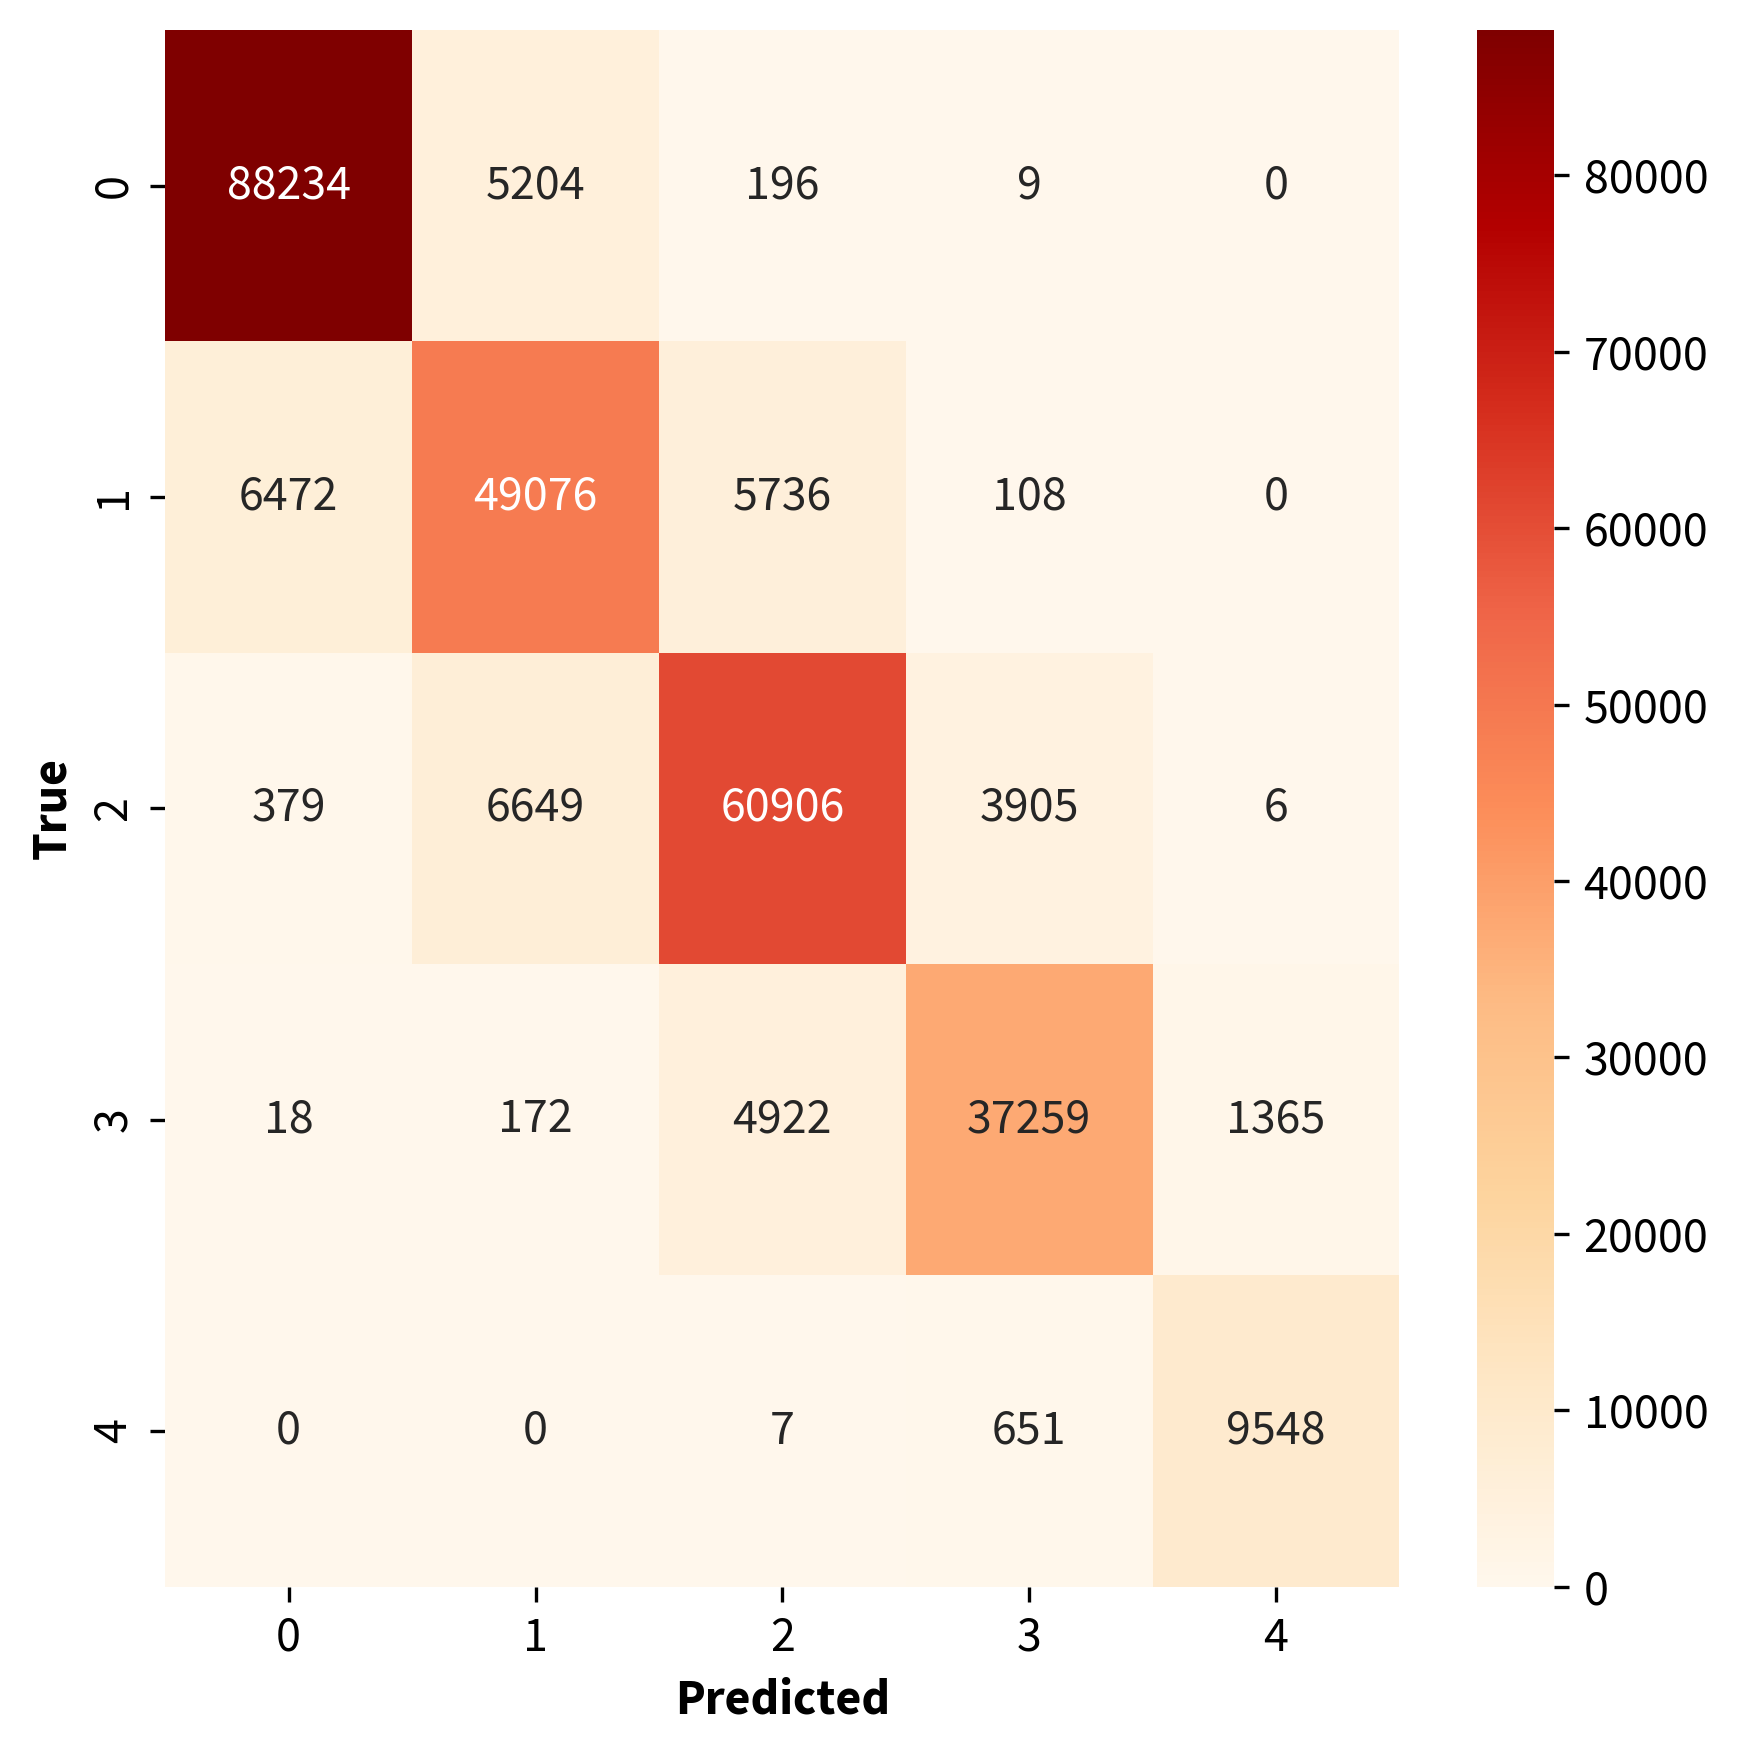

Done in total duration: 287.0672860145569
Scenario: present-day, Features: Detailed, Accuracy: 0.8835988633369181, Duration: 312.2199454307556
Confusion matrix for present-day and Detailed


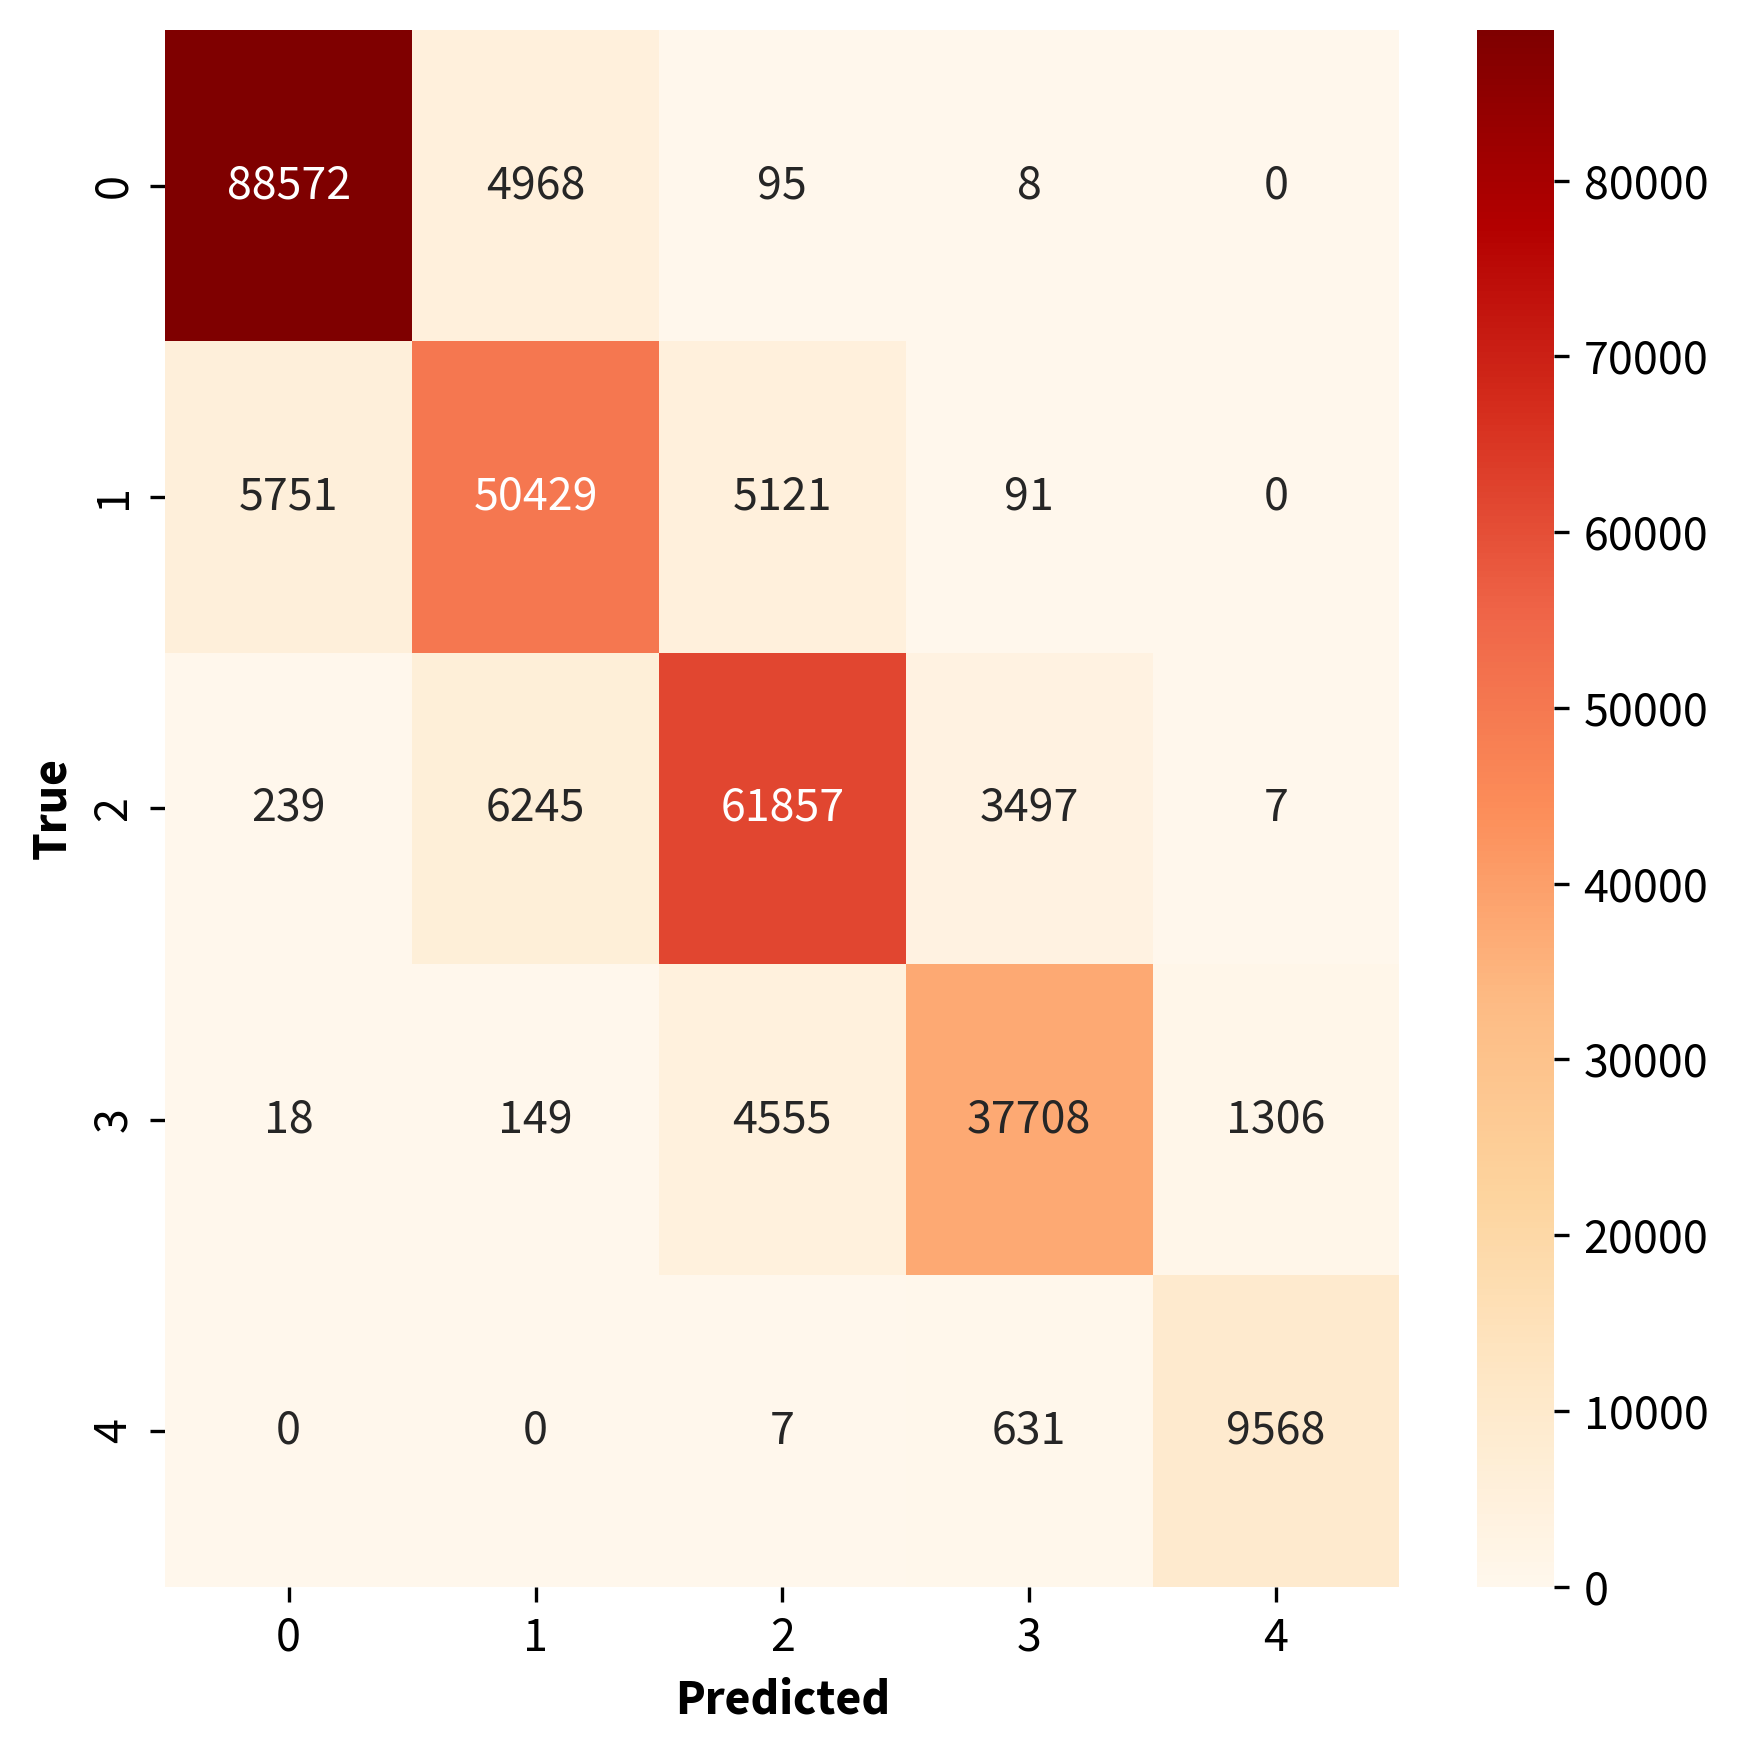

Done in total duration: 324.15701055526733


In [3]:
#%% Testing the features reduction and aggregation

plot = True # Change to True to plot the correlation matrix

period = [["2023-01-01 00:00:00" , "2023-3-31 23:00:00"], ["2023-12-01 00:00:00" , "2023-12-31 23:00:00"]] # Summer period

scenarios = ['present-day'] # Present day climate
target = 'heat_stress_category' # Target variable (0 to 4 scale from no heat stress to extreme heat stress)

# Use RandomForestClassifier to get the feature importances and plot confusion matrix and classification report as well as duration of the training
feature_importances = {}
performance = {}
for scenario in scenarios:
    feature_importances[scenario] = {}
    performance[scenario] = {}
    for sets in ['Highly-Aggregated', 'Aggregated', 'Reduced', 'Detailed']:
        # Initialize dictionaries
        feature_importances[scenario][sets] = {}
        performance[scenario][sets] = {}

        # Get the features sets
        features = get_features_sets(sets)

        # Get the data
        X, y = get_data(scenario, features, target, scaler=True, periods=period)
        
        # Balance data
        X, y = balance_data(X, y)

        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

        # Train model
        start = time.time() # Start timer
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)
        duration = time.time() - start # Get duration (performance indicator)

        # Get feature importances
        feature_importances[scenario][sets] = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

        # Get performance
        y_pred = rf.predict(X_test)
        performance[scenario][sets] = {'accuracy': accuracy_score(y_test, y_pred),
                                        'confusion_matrix': confusion_matrix(y_test, y_pred),
                                        'classification_report': classification_report(y_test, y_pred),
                                        'duration': duration}
        
        print(f"Scenario: {scenario}, Features: {sets}, Accuracy: {performance[scenario][sets]['accuracy']}, Duration: {performance[scenario][sets]['duration']}")

        # Plot confusion matrix
        print(f"Confusion matrix for {scenario} and {sets}")
        
        fig = plt.figure(figsize=(6, 6))
        sns.heatmap(performance[scenario][sets]['confusion_matrix'], annot=True, fmt='g', cmap='OrRd')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        # plt.title(f"Confusion matrix for {scenario} and {sets}")
        plt.tight_layout()
        plt.savefig(f"../figures/features_selection/confusion_matrix_{scenario}_{sets}.png", dpi=300)
        if plot==True:
            plt.show()
        else: 
            plt.close()
            print(f"Confusion matrix saved for {scenario} and {sets} as ../figures/features_selection/confusion_matrix_{scenario}_{sets}.png")
        
        total_duration = time.time() - start # Get total duration (indicative)

        print(f"Done in total duration: {total_duration}")

# Save feature importances and performance for later use
for scenario in feature_importances.keys():
    for sets in feature_importances[scenario].keys():
        feature_importances[scenario][sets].to_csv(f"../results/features/feature_importances_{scenario}_{sets}.csv")
        # Save performance to json and convert numpy arrays to lists
        performance[scenario][sets]['confusion_matrix'] = performance[scenario][sets]['confusion_matrix'].tolist()
        performance[scenario][sets]['classification_report'] = performance[scenario][sets]['classification_report'].replace('\n', ' ')
        with open(f"../results/features/performance_{scenario}_{sets}.json", 'w') as f:
            json.dump(performance[scenario][sets], f, indent=4)